# Построение модели на примере полиномиальной регрессии (polynomial regression) с использованием `sklearn.pipeline`

## Подготовка окружения

In [1]:
# ВНИМАНИЕ: необходимо удостовериться, что виртуальная среда выбрана правильно!

# Для MacOS/Ubuntu
# !which pip

# Для Windows
# !where pip

In [2]:
# !conda install matplotlib numpy scikit-learn seaborn scipy -y

In [3]:
import numpy as np

np.__version__

'1.19.2'

In [4]:
import pandas as pd

pd.__version__

'1.2.3'

In [5]:
import scipy
from scipy import stats

scipy.__version__

'1.6.2'

In [6]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.__version__

'3.3.4'

In [7]:
import seaborn as sns

sns.__version__

'0.11.1'

## Загрузка данных

[Источник (FuelConsumption)](https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64)

In [8]:
df = pd.read_csv("./../../data/FuelConsumptionCo2.csv")
df

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,2014,VOLVO,XC60 AWD,SUV - SMALL,3.0,6,AS6,X,13.4,9.8,11.8,24,271
1063,2014,VOLVO,XC60 AWD,SUV - SMALL,3.2,6,AS6,X,13.2,9.5,11.5,25,264
1064,2014,VOLVO,XC70 AWD,SUV - SMALL,3.0,6,AS6,X,13.4,9.8,11.8,24,271
1065,2014,VOLVO,XC70 AWD,SUV - SMALL,3.2,6,AS6,X,12.9,9.3,11.3,25,260


## Преобразование типов и очистка

In [9]:
# удалить бессмысленную колонку
del df['MODELYEAR']

In [10]:
# преобразовать в правильные типы
df.MODEL = df.MODEL.astype("string")

for col_name in df.select_dtypes(include='object'):
    df[col_name] = df[col_name].astype("category")

In [11]:
df.ENGINESIZE = df.ENGINESIZE.astype(pd.CategoricalDtype(ordered=True))
df.CYLINDERS = df.CYLINDERS.astype(pd.CategoricalDtype(ordered=True))

## Разделение данных на `X` и `y`

In [12]:
from sklearn.model_selection import train_test_split

y = df['CO2EMISSIONS'].copy()
X = df.loc[:, df.columns != 'CO2EMISSIONS'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Анализ и обработка выбросов

In [13]:
def remove_outliers_iqr(data, col_name):
    print(f"column name: {col_name}\n")
    Q1 = data[col_name].quantile(0.25)
    Q3 = data[col_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR
    data_new = data[~((data[col_name] < lower_fence) |
                      (data[col_name] > upper_fence))]
    
    diff_len = len(data) - len(data_new)
    print(f"removed: {diff_len}")
    
    _, axs = plt.subplots(1, 2, figsize=(10, 2))
    sns.boxplot(data=data_new[col_name], ax=axs[0])
    sns.histplot(data=data_new[col_name], ax=axs[1])
    
    return data_new.reset_index(drop=True)

len(df_tmp) BEFORE: 853
column name: FUELCONSUMPTION_CITY

removed: 21
------------------------------ 

column name: FUELCONSUMPTION_HWY

removed: 12
------------------------------ 

column name: FUELCONSUMPTION_COMB

removed: 5
------------------------------ 

column name: FUELCONSUMPTION_COMB_MPG

removed: 14
------------------------------ 

column name: CO2EMISSIONS

removed: 4
------------------------------ 

len(df_tmp) AFTER: 797


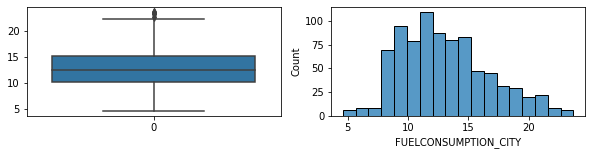

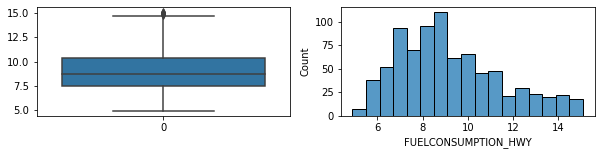

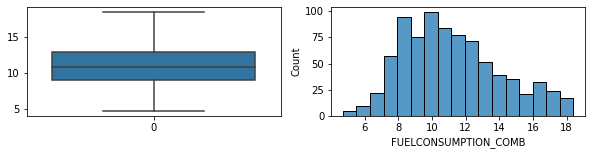

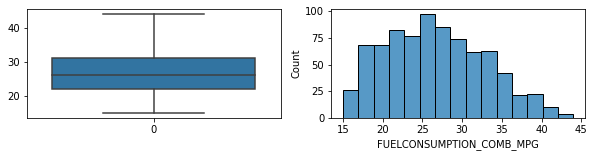

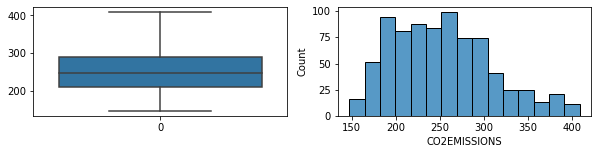

In [14]:
df_tmp = X_train.join(y_train).reset_index(drop=True)
print('len(df_tmp) BEFORE:', len(df_tmp))
for col_name in df.select_dtypes(include=np.number):
    df_tmp = remove_outliers_iqr(df_tmp, col_name)
    print("-"*30, '\n')
print('len(df_tmp) AFTER:', len(df_tmp))

X_train = df_tmp.loc[:, df_tmp.columns != 'CO2EMISSIONS'].copy()
y_train = df_tmp['CO2EMISSIONS'].copy()

## Pipeline

In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [16]:
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

In [17]:
CYLINDERS_transformer = Pipeline(steps=[
    ('replace', FunctionTransformer(lambda x: x.replace(to_replace=
                                                           {3: 4, 
                                                            5: 4, 
                                                            10: 8,
                                                            12: 8}))),
     ('encoder_ord', OrdinalEncoder())])
CYLINDERS_transformer

Pipeline(steps=[('replace',
                 FunctionTransformer(func=<function <lambda> at 0x7f7e0142fee0>)),
                ('encoder_ord', OrdinalEncoder())])

In [18]:
ENGINESIZE_transformer = Pipeline(steps=[
    ('round', FunctionTransformer(lambda x: x.astype(float).round(0))),
    ('replace', FunctionTransformer(lambda x: x.replace(to_replace={1: 2, 
                                                                    7: 8, 
                                                                    8: 6}))),
    ('encoder', OrdinalEncoder())
    ])
ENGINESIZE_transformer

Pipeline(steps=[('round',
                 FunctionTransformer(func=<function <lambda> at 0x7f7de2029dc0>)),
                ('replace',
                 FunctionTransformer(func=<function <lambda> at 0x7f7de2029e50>)),
                ('encoder', OrdinalEncoder())])

In [19]:
FUELTYPE_transformer = Pipeline(steps=[
    ('replace', FunctionTransformer(lambda x: x.replace('D', 'X'))), 
    ('encoder_oh', OneHotEncoder()) 
    ])
FUELTYPE_transformer

Pipeline(steps=[('replace',
                 FunctionTransformer(func=<function <lambda> at 0x7f7de203a040>)),
                ('encoder_oh', OneHotEncoder())])

In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_CYLINDERS', CYLINDERS_transformer, ['CYLINDERS']),
        ('categorical_ENGINESIZE', ENGINESIZE_transformer, ['ENGINESIZE']),
        ('categorical_FUELTYPE', FUELTYPE_transformer, ['FUELTYPE']),
        ('numeric_FUELCONSUMPTION_COMB_MPG', numeric_transformer, ['FUELCONSUMPTION_COMB_MPG']),
        ('drop', 'drop', df.columns.difference(['FUELCONSUMPTION_COMB_MPG', 'CYLINDERS', 'ENGINESIZE', 'FUELTYPE', 'CO2EMISSIONS']).tolist()),
]) 

In [21]:
pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures()),
    ('model', LinearRegression())
])

In [22]:
# Параметры конвейеров могут быть заданы с использованием имен параметров, разделенных __
param_grid = {
    'poly__degree': [1, 2, 3]
}
model_gcv = GridSearchCV(pipeline, param_grid, n_jobs=-1)
model_gcv.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % model_gcv.best_score_)
print(model_gcv.best_params_)

Best parameter (CV score=0.986):
{'poly__degree': 2}


In [23]:
from sklearn import set_config                      # to change the display
from sklearn.utils import estimator_html_repr       # to save the diagram into HTML format

# set config to diagram for visualizing the pipelines/composite estimators
set_config(display='diagram')

# saving pipeline as html format
with open('./tmp/pipeline.html', 'w') as f:  
    f.write(estimator_html_repr(model_gcv.best_estimator_))
    
# the best estimator from grid search
model_gcv.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical_CYLINDERS',
                                                  Pipeline(steps=[('replace',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7f7e0142fee0>)),
                                                                  ('encoder_ord',
                                                                   OrdinalEncoder())]),
                                                  ['CYLINDERS']),
                                                 ('categorical_ENGINESIZE',
                                                  Pipeline(steps=[('round',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7f7de2029dc0>)),
                                                                  ('replace...
                                                                  ('encoder_oh',
                                                                   OneHotEncoder())]),
                                                  ['FUELTYPE']),
                                                 ('numeric_FUELCONSUMPTION_COMB_MPG',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['FUELCONSUMPTION_COMB_MPG']),
                                                 ('drop', 'drop',
                                                  ['FUELCONSUMPTION_CITY',
                                                   'FUELCONSUMPTION_COMB',
                                                   'FUELCONSUMPTION_HWY',
                                                   'MAKE', 'MODEL',
                                                   'TRANSMISSION',
                                                   'VEHICLECLASS'])])),
                ('poly', PolynomialFeatures()), ('model', LinearRegression())])

In [24]:
model_gcv.best_estimator_['poly'].n_input_features_, model_gcv.best_estimator_['poly'].n_output_features_

(6, 28)

In [25]:
model_gcv.best_estimator_['poly'].powers_

array([[0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1],
       [2, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [1, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 1],
       [0, 2, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0],
       [0, 1, 0, 1, 0, 0],
       [0, 1, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 1],
       [0, 0, 2, 0, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 0, 1],
       [0, 0, 0, 2, 0, 0],
       [0, 0, 0, 1, 1, 0],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 2]])

In [26]:
# оценить модель
y_predicted = model_gcv.predict(X_test)

print("Mean absolute error: %.2f" % np.mean(np.absolute(y_predicted - y_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_predicted - y_test) ** 2))
print("R2-score: %.2f" % r2_score(y_true=y_test, y_pred=y_predicted))

Mean absolute error: 5.50
Residual sum of squares (MSE): 121.08
R2-score: 0.97


## Cross-validation

[sklearn.model_selection.cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

In [27]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model_gcv.best_estimator_, X_test, y_test, cv=5)
print(f"scores: {scores}")
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores: [0.98037901 0.98856009 0.97544175 0.97572825 0.97996871]
0.98 accuracy with a standard deviation of 0.00
